In [1]:
from matplotlib import pyplot, patches
from matplotlib.path import Path
from numpy import matrix, pi, cos, sin, array, mean, allclose
from numpy.linalg import svd
from numpy.random import random, normal
from scipy.spatial import cKDTree

In [2]:
%matplotlib inline

In [3]:
target = random((6, 2))
target = array(target)

In [4]:
theta = random() * pi - pi / 2
b = random((2, 1)) * 2 - 1

In [5]:
R = matrix([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

In [6]:
source = (R * target.T).T + b.T + normal(0, .05, target.shape)

In [7]:
codes = [Path.MOVETO] + [Path.LINETO] * (len(source) - 2) + [Path.CLOSEPOLY]

def visualize(target, source, name=None):
    path_target = Path(target, codes)
    path_source = Path(source, codes)
    fig = pyplot.figure()
    ax = fig.add_subplot(111)
    patch_target = patches.PathPatch(path_target, facecolor='yellow', alpha=0.5)
    patch_source = patches.PathPatch(path_source, facecolor='blue', alpha=0.5)
    ax.add_patch(patch_target)
    ax.add_patch(patch_source)
    pyplot.grid(True)
    pyplot.axis('equal')
    pyplot.autoscale(True)
    if isinstance(name, str):
        pyplot.savefig('{}.png'.format(name))

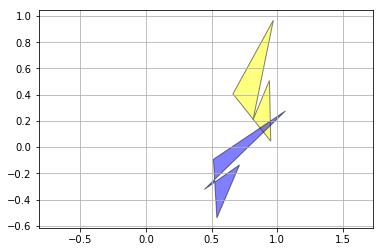

In [8]:
visualize(target, source, '0')

In [9]:
tree = cKDTree(target)

def find_labeling(target, source):
    return target[tree.query(source)[1]]

In [10]:
def find_transformation(nearest_neighbours, source):
    centroid_target = mean(nearest_neighbours, axis=0)
    centroid_source = mean(source, axis=0)
    H = ((nearest_neighbours - centroid_target).T).dot(source - centroid_source)
    U, S, V = svd(H)
    R = (U.T).dot(V.T)
    t = centroid_target - R.dot(centroid_source.T).T
    return R.dot(source.T).T + t

In [11]:
def icp(target, source, max_iterations=int(1E6)):
    labelings = []
    transformations = []
    labelings.append(find_labeling(target, source))
    transformations.append(find_transformation(labelings[0], source))
    visualize(target, transformations[-1], '1')
    i = 1
    while len(labelings) < 2 or not allclose(labelings[-1], labelings[-2]) and i < max_iterations:
        i += 1
        labelings.append(find_labeling(target, transformations[-1]))
        transformations.append(find_transformation(labelings[-1], transformations[-1]))
        visualize(target, transformations[-1], str(i))
    print 'Number of iterations:', i
    return transformations

Number of iterations: 6


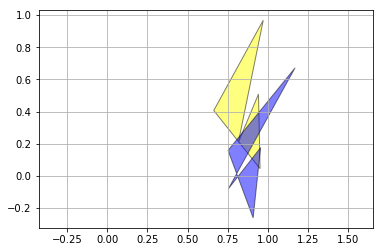

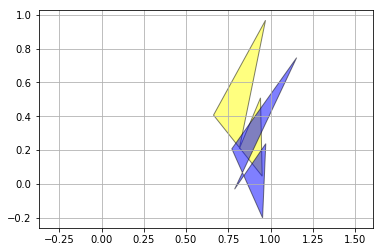

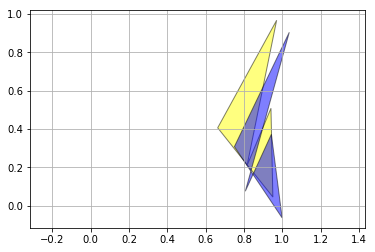

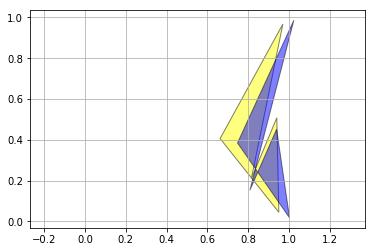

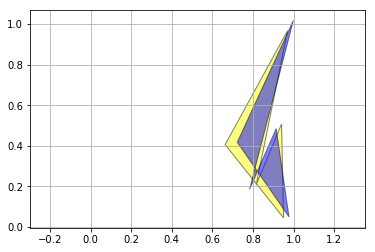

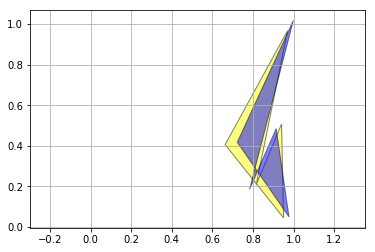

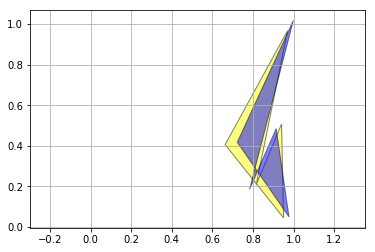

In [12]:
visualize(target, icp(target, source)[-1])

In [13]:
print 'R\n{}\nb\n{}\ntarget\n{}\nsource\n{}'.format(R, b, target, source)

R
[[ 0.84966843  0.52731733]
 [-0.52731733  0.84966843]]
b
[[-0.28417183]
 [-0.07909832]]
target
[[ 0.81614017  0.20937208]
 [ 0.94089495  0.50824402]
 [ 0.95078479  0.04485682]
 [ 0.66280856  0.40614803]
 [ 0.97055689  0.96760491]
 [ 0.1107779   0.25888522]]
source
[[ 0.44483798 -0.32255809]
 [ 0.71295425 -0.135242  ]
 [ 0.54009608 -0.53989112]
 [ 0.51395228 -0.09298822]
 [ 1.06352634  0.27627191]
 [-0.1496124   0.10162129]]
